# Demo for training and using the VRES_CNN model in Keras

If useful, please cite the paper:
R. Dogaru and Ioana Dogaru, "VRES-CNN: A Tiny Convolutional Image
Classifier with Versatile Choice of Hyperparameters", in Proceedings ECAI 2024.

# 0 - Load data (some extra-dataset may be required)

In [3]:
!pip install extra-keras-datasets
from extra_keras_datasets import emnist, svhn, stl10
# EMNIST may not be functional as of may 27, 2024

In [1]:
import numpy as np
import keras
datagen=False
dataset='cifar10' # mnist or f-mnist or cifar10
reduced=0  #  a positive value represents a reduced number of training samples (when memory allocation problems occur)
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist


if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
elif  dataset=='cifar10':
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
elif  dataset=='cifar100':
    (x_train, y_train), (x_test, y_test) = cifar100.load_data()
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()
elif dataset=='emnist':
    (x_train, y_train), (x_test, y_test) =  emnist.load_data()
elif dataset=='svhn':
    (x_train, y_train), (x_test, y_test) =  svhn.load_data()
elif dataset=='stl10':
    (x_train, y_train), (x_test, y_test) =  stl10.load_data()

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1])
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] )
# place a  1 in the end to keep it compatible with kernel in conv2d
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255
inp_chan=np.shape(x_train)[3]
print('Number of input channels in image:', inp_chan)
num_classes=int(np.max(y_train)+1)
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]
imsize=input_shape[0]

# if reduced >0
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('Training samples: ',np.shape(x_train)[0]); print('Validation samples: ',np.shape(x_test)[0]);
print('Input data shape : ', np.shape(x_train)[1], 'x', np.shape(x_train)[2] )
print('Number of classes: ',num_classes)

2024-05-27 13:51:32.641804: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-27 13:51:32.641892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-27 13:51:32.776187: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Number of input channels in image: 3
Training samples:  50000
Validation samples:  10000
Input data shape :  32 x 32
Number of classes:  10


# 1 -   Define VRES-CNN model (less compact V-CNN included also)
For V-CNN detalils: https://github.com/radu-dogaru/V-CNN

In [2]:
# Model VRES-CNN
# Copyright Radu & Ioana Dogaru, May 2024
# code in support of paper
# R. Dogaru and Ioana Dogaru, "VRES-CNN: A Tiny Convolutional Image Classifier with Versatile Choice of Hyperparameters", in Proceedings ECAI 2024.

#-----------------------------------------------------------------------
import numpy as np
from keras.layers import Input, Conv2D, SeparableConv2D, ReLU, BatchNormalization,\
                                    Add, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, \
                                    Flatten, Dense, Dropout, Activation, Identity, Concatenate
from keras.models import Model
sparse=False # depends on datasets


def svcnn_resblock(x, filters, nl, resid=True, separ=True):
    # filters and nl regarding macro-block
    # csize=3 = economical, 5 gives faster convergence but not so light
    csize=3; stri=2; psiz=3; pad='same';
    drop1=0.6 # One may try other values e.g. 0.5
    if nl>0:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(x)
        z=y
        y=Activation('relu')(y)
        for nonlin in range(1,nl):
            if separ:
                y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            else:
                y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)  # aici era (z) inainte de 5 iul ora 20
            y=Activation('relu')(y)
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize))(y)# Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize))(y)#
    else:
        if separ:
            y=SeparableConv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        else:
            y=Conv2D(filters, padding=pad, kernel_size=(csize, csize) )(x)  # Activ NL-CNN-2
        z=y

    if resid:
        out = Add()([z, y])
    else:
        out=y
    out=BatchNormalization()(out)  # Comment if no batch normalization ...
    out=MaxPooling2D(pool_size=(psiz, psiz),strides=(stri,stri),padding=pad)(out)
    out=Dropout(drop1)(out)   # If missing, very low performance and overfit present.


    return out

def create_vres_cnn(input_shape, num_classes, flat=1, fil=[100,100,100,100], nl=[1,1,0,0], hid=[], resid=True, separ=True):
    # Note the number of elements in fil list (macrolayers) should be the same in nl list
    # hid can be [] while if the are elements, additional dense layers are added in the output classifier
    my_opt=keras.optimizers.Adam(learning_rate=0.01) # may be changed
    nfilmax=np.shape(np.array(fil))[0]

    inputs = Input(shape=input_shape) # / 255  # scaling
    #============= MODULE MAIN =======================================================
    # First macrolayer - connected to input  ----------------
    layer=0
    #print('layer: ',layer,' nl: ',nl[layer])
    t=svcnn_resblock(inputs, fil[layer], nl[layer], resid, separ)
    for layer in range(1,nfilmax):
        #print('layer: ',layer,' nl: ',nl[layer])
        t=svcnn_resblock(t, fil[layer], nl[layer], resid, separ)

    # Exit classifier
    # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice )
    if flat==1:
        t=Flatten()(t)  #
    elif flat==0:
        t=GlobalAveragePooling2D()(t) #
    #=============== END MODULE MAIN - BEGIN MODULE 2 =================

    nhid=np.shape(np.array(hid))[0]
    if nhid>0:
        for lay in range(nhid):
            t=Dense(hid[lay], activation='relu')(t)
            #model.add(Dropout(drop1))
    outputs =Dense(num_classes, activation='softmax')(t)
    model = Model(inputs, outputs)
# END OF MODEL DESCRIPTION
    if sparse:
        model.compile(
            optimizer=my_opt,
            #optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
            loss = 'sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy']
            )
    else:
        model.compile(loss='categorical_crossentropy',
                      optimizer=my_opt,
                      metrics=['accuracy'])
    model.build(input_shape)
    return model

# 2  - construct a VRES-CNN model with specific hyper-params.

In [3]:

version='VRESCNN' # VRESCNN or VCNN
myflat=0; myfil=[80,100,40]; mynl=[2,1,1]; myhid=[]   # aici se pot testa diferite alte valori

if version=='VRESCNN':
    my_resid=True
    my_separ=True
elif version == 'VCNN':
    my_resid=False
    my_separ=False

model=create_vres_cnn(input_shape, num_classes, flat=myflat, fil=myfil, nl=mynl, hid=myhid, resid=my_resid, separ=my_separ)
model_name=version+'_'+str(myflat)+'_'+str(myfil)+'_'+str(mynl)+'_'+str(myhid)
print(model_name)
model.summary()



VRESCNN_0_[80, 100, 40]_[2, 1, 1]_[]


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 32, 32,    │        347 │ input_layer[0][0] │
│ (SeparableConv2D)   │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ separable_conv2d… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 32, 32,    │      7,200 │ activation[0][0]  │
│ (SeparableConv2D)   │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ separable_conv2d… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 32, 32,    │      7,200 │ activation_1[0][… │
│ (SeparableConv2D)   │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ separable_conv2d… │
│                     │ 80)               │            │ separable_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │        320 │ add[0][0]         │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 16, 16,    │      8,820 │ dropout[0][0]     │
│ (SeparableConv2D)   │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 16, 16,    │          0 │ separable_conv2d… │
│ (Activation)        │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 16, 16,    │     11,000 │ activation_2[0][… │
│ (SeparableConv2D)   │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 16, 16,    │          0 │ separable_conv2d… │
│                     │ 100)              │            │ separable_conv2d… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        400 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 100)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 8, 100) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 100) │          0 │ max_pooling2d_1[

 Total params: 42,797 (167.18 KB)

 Trainable params: 42,357 (165.46 KB)

 Non-trainable params: 440 (1.72 KB)

# Prepare for training - best model (best val_accuracy) saving

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import time as ti
checkpoint = ModelCheckpoint('best_model.keras', monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose=1)

# 2- Training

In [5]:
epoci=50  # epochs number
if datagen==False:
    batch_size=100  # batch_size to be defined here
import time as ti
t1=ti.time()

#
if datagen:
  history = model.fit(train_generator, epochs=epoci, validation_data=validation_generator, verbose=1,
                    callbacks = checkpoint)
else:
  history = model.fit(x_train, y_train, epochs=epoci, validation_data=(x_test, y_test), batch_size=batch_size, verbose=1,
                    callbacks = checkpoint)

t2=ti.time()
print('====================================================')
print('Training with  ',epoci,' epochs, lasted  ',int(t2-t1)/60,' minutes')

model=load_model('best_model.keras')

t1=ti.time()
if datagen:
    score = model.evaluate(validation_generator, verbose=0)
else:
    score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()

print('--------------  Report  ------------------------')
print ('Model size (K-params): ',model.count_params()//1000)
print('Best validation accuracy :', 100*score[1],'%')
print ('Prediction time per entire validation set: ',t2-t1)
print('Latency (per sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')
print('Dataset : ',dataset)
print('Model: ',model_name)
print('Image size: ',imsize)
print('Batch size: ', batch_size)

Epoch 1/50
 10/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.1082 - loss: 2.7488 

I0000 00:00:1716817948.710294     105 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3399 - loss: 1.7875
Epoch 1: val_accuracy improved from -inf to 0.42800, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 21ms/step - accuracy: 0.3403 - loss: 1.7865 - val_accuracy: 0.4280 - val_loss: 2.0751
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5614 - loss: 1.2119
Epoch 2: val_accuracy improved from 0.42800 to 0.50180, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5614 - loss: 1.2119 - val_accuracy: 0.5018 - val_loss: 1.5407
Epoch 3/50
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6124 - loss: 1.0808
Epoch 3: val_accuracy improved from 0.50180 to 0.62450, saving model to best_model.keras
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6124 - loss: 1.0808 - val_accuracy: 0.6245 - val_loss: 1.0814
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6391 - loss: 1.0098
Epoch 4: val_accuracy improved from 0.62450 

# Display training graphs

/tmp/ipykernel_34/1304787030.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


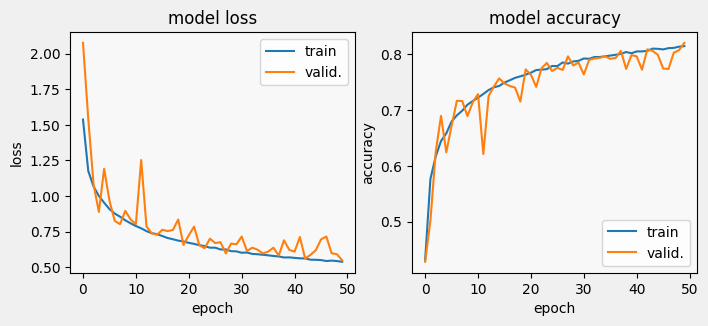

In [6]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(7,3), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 121)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 122)

In [21]:
# Saving model
#-----------------------------------------------------------

model.save('myname.keras')  # use your favourite name

# Conversion to tflite  (only in Keras 2.x) 

In [22]:
if keras.__version__[0]=='2':
    import tensorflow as tf
    converter=tf.lite.TFLiteConverter.from_keras_model(model)
    converter.post_training_quantize=True  #
    tflite_model=converter.convert()
    myname='tflite_xx'
    open(myname,'wb').write(tflite_model)
elif keras.__version__[0]=='3':
    print('On this platform Keras 3 is installed ; Do restart and !pip install keras==2.15.0')

On this platform Keras 3 is installed ; Do restart and !pip install keras==2.15.0
